## Assignment 7: Implementing a DCGAN for the MNIST Fashion Dataset

Group: Group 3<br>
Authors: Navjot Kaur, Qichun Yu

### Part 1: Generating Key Functions
Main author: Navjot Kaur

1. Create a new Jupyter notebook and import the necessary libraries.

In [1]:
# Import the required library functions
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers \
import Reshape, Dense, Dropout, Flatten,Activation
from tensorflow.keras.layers import LeakyReLU,BatchNormalization
from tensorflow.keras.layers import Conv2D,UpSampling2D,Conv2DTranspose
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.optimizers import Adam

2. Define the function that will generate a real data distribution from the MNIST fashion dataset, as done in Exercise 7.05. Create a batch of 16 sample images and plot them in a 4 by 4 grid. Describe the plot in words.

In [2]:
(X_train, _),(_, _) = fashion_mnist.load_data()
X = X_train.reshape(-1, 28, 28, 1)
print(X.shape)
#X = X_train[:, :, :, np.newaxis]
#X = (X-127.5)/127.5
#print(X[np.random.randint(0, X.shape[0], size=2)])

(60000, 28, 28, 1)


In [3]:
# Function to generate real data samples
def realData(batch):
    # Get the fashion MNIST data 
    (X_train, _), (_, _) = fashion_mnist.load_data()
    # Reshaping the input data to include channel
    X = X_train[:,:,:,np.newaxis]
    # normalising the data
    X = (X.astype('float32') - 127.5)/127.5
    # Generating a batch of data
    imageBatch = X[np.random.randint(0, X.shape[0], size=batch)]
    return imageBatch

In [4]:
# create a batch of 16 sample images
fashionData = realData(16)

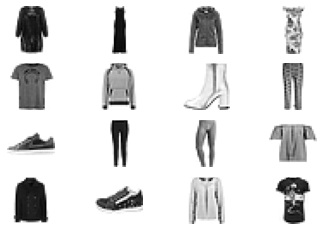

In [5]:
# Plot them in a 4 by 4 grid
for j in range(4*4):
    pyplot.subplot(4, 4, j+1)
    pyplot.axis('off')
    pyplot.imshow(fashionData[j, :, :, 0], cmap='gray_r')

**Comments:**<br>
From the plot above, we can see the visualization of 16 (4*4) fashion images such as shoes, clothes, pants, and so on. The images are in white background with gray colour since we set the cmap='gray_r'. 

3. Define a function for generating fake inputs from a random uniform distribution, as done in Exercise 7.05. The inputs are random data points that are generated from a random uniform distribution 

In [6]:
# Function to generate inputs
def fakeInputs(batch, infeats):
    # generate random noise data with shape
    x_fake = np.random.uniform(-1, 1, size=[batch, infeats])
    return x_fake

#test = fakeInputs(2,3)
#print(test)

4. Define a function for building the generator network, as done in Exercise 7.05. Note that some lines are missing from the solution in the textbook. Building the generator network is similar to building any CNN network. In this generator network, we will use the transpose convolution method for upsampling images. The initial input starts with a dimension of 100, which is our input feature. The dimension of the MNIST dataset is batch size x 28 x 28. For better performance, your function should use the Conv2DTranspose function twice to get the output as batch size x 28 x 28 in two stages.

In [7]:
# Function for the generator model
def genModelfunc(infeats):
    Genmodel = Sequential()
    Genmodel.add(Dense(512, input_dim = infeats))
    Genmodel.add(Activation('relu'))
    Genmodel.add(BatchNormalization())
    # second layer of FC => RElu => BN layers
    Genmodel.add(Dense(7*7*64))
    Genmodel.add(Activation('relu'))
    Genmodel.add(BatchNormalization())
    # Upsample to 14 x 14
    Genmodel.add(Reshape((7,7,64)))
    Genmodel.add(Conv2DTranspose(32,kernel_size=(5,5),strides=(2,2),padding='same'))
    Genmodel.add(Activation('relu'))
    Genmodel.add(BatchNormalization(axis = -1))
    # Updample to 28 x 28
    Genmodel.add(Conv2DTranspose(1,kernel_size=(5,5),strides=(2,2),padding='same'))
    Genmodel.add(Activation('tanh'))    
    return Genmodel

5. Define the function that will be used to create fake samples, as done in Exercise 7.05.

In [8]:
# Function to create fake samples using the generator model
def fakedataGenerator(Genmodel, batch, infeats):
    # first generate the inputs to the model
    genInputs = fakeInputs(batch, infeats)
    """
    use these inputs inside the generator model
    to generate fake distribution
    """
    X_fake = Genmodel.predict(genInputs)
    
    return X_fake

6. Create the generator model and print a summary.

In [9]:
# Define the arguments like batch size and input feature
batch = 128
infeats = 100
Genmodel = genModelfunc(infeats)
Genmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               51712     
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              1608768   
_________________________________________________________________
activation_1 (Activation)    (None, 3136)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3136)              12544     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0

7. Use the generator function to generate a fake sample. Print out the shape of the sample and plot the image.

In [10]:
# Generating a fake sample and printing the shape
fake = fakedataGenerator(Genmodel, batch, infeats)
fake.shape

(128, 28, 28, 1)

Text(0.5, 0, 'Fake Sample Image')

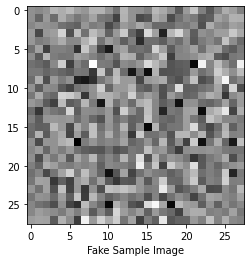

In [11]:
# Plotting the fake sample

plt.imshow(fake[1, :, :, 0], cmap='gray_r')

plt.xlabel('Fake Sample Image')

8. Create a function that builds the discriminator network. Use the function to create a discriminator network, and print a summary of the model.

In [12]:
# Descriminator model as a function
def discModelfunc():
    Discmodel = Sequential()
    Discmodel.add(Conv2D(32,kernel_size=(5,5),strides=(2,2),padding='same',input_shape=(28,28,1)))    
    Discmodel.add(LeakyReLU(0.2))
    # second layer of convolutions
    Discmodel.add(Conv2D(64, kernel_size=(5,5), strides=(2, 2), padding='same'))   
    Discmodel.add(LeakyReLU(0.2))
    # Fully connected layers
    Discmodel.add(Flatten())
    Discmodel.add(Dense(512))
    Discmodel.add(LeakyReLU(0.2))
    Discmodel.add(Dense(1, activation='sigmoid'))
    Discmodel.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5),metrics=['accuracy'])   
    return Discmodel 

In [13]:
# Print the summary of the discriminator model
Discmodel = discModelfunc()
Discmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1606144   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)              

9. Create a function that builds the GAN model. You can take cues from Exercise 7.05, Implementing the DCGAN, on how to do this. Use the function to build a GAN model, and print a summary of the model.

In [14]:
"""
Define the combined generator and discriminator model, for updating the generator
"""
def ganModelfunc(Genmodel, Discmodel):
    # First define that discriminator model cannot be trained
    Discmodel.trainable = False
    Ganmodel = Sequential()
    # First adding the generator model
    Ganmodel.add(Genmodel)
    # Next adding the discriminator model without training the parameters
    Ganmodel.add(Discmodel)
    # Compile the model for loss to optimise the Generator model
    Ganmodel.compile(loss='binary_crossentropy', optimizer = Adam(lr=0.0002, beta_1=0.5))
    return Ganmodel

In [15]:
# Initialise the gan model
gan_model = ganModelfunc(Genmodel, Discmodel)
# Print summary of the GAN model
gan_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 28, 28, 1)         1727233   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1658753   
Total params: 3,385,986
Trainable params: 1,719,873
Non-trainable params: 1,666,113
_________________________________________________________________


### Part 2: The Training Process:
Main author: Qichun Yu

**Question 1 & Question 2**

1. Create a loop to do the following for nEpochs iterations. (Try setting nEpochs = 5000.) Add a comment before writing code for each section below, to explain what the section of code does.

In [16]:
# Defining the number of epochs
nEpochs = 5000

In [17]:
# Train the GAN network
for i in range(nEpochs):
    # 1a. Generate samples equal to the bath size from the real distribution
    x_real = realData(batch)
    # 1b. Generate fake samples using the fake data generator function
    x_fake = fakedataGenerator(Genmodel,batch,infeats)
    # 1c. Concatenating the real and fake data 
    X = np.concatenate([x_real,x_fake])
    # Creating the dependent variable and initializing them as '0'
    Y = np.zeros(batch * 2)
    # making the first set equivalent to batch with labels 1
    Y[:batch] = 1.
    # 1d. train the  discriminator on the real samples
    discLoss = Discmodel.train_on_batch(X, Y)
    # 1e. Generate new fake inputs for training the GAN network
    x_gan = fakeInputs(batch*2,infeats)
    # Create labels of the fake examples as 1 to fool the discriminator
    y_gan = np.ones((batch*2, 1))
    # 1f. Update the generator model through the discriminator model
    gan_model.train_on_batch(x_gan, y_gan)
    # Print the accuracy measures on the real and fake data for every 10 epochs
    if (i) % 50 == 0:
        # Printing the descriminator loss and accuracy
        x_real_test = realData(10)
        x_fake_test = fakedataGenerator(Genmodel,10,infeats)
        # Concatenating the real and fake data 
        X_test = np.concatenate([x_real_test,x_fake_test])
        # Creating the dependent variable and initializing them as '0'
        Y = np.zeros(10 * 2)
        Y[:10] = 1.
        # 2a. use the discriminator model Predicting probabilities
        preds = np.round(Discmodel.predict(X_test))
        acc = 1.0 - np.sum(np.abs(preds.reshape(-1) - Y))/len(Y)
        # 2b. print the mean discriminator probability for the samples
        print('Epoch:',i,'\tDiscriminator probability:', acc)
        # Generate fake samples using the fake data generator function
        x_fake = fakedataGenerator(Genmodel,batch,infeats)
        # 2c. Plot 16 of the fake samples in a grid.
        # Saving the plots
        for j in range(4*4):
            pyplot.subplot(4,4,j+1)
            # turn off axis 
            pyplot.axis('off')
            pyplot.imshow(x_fake[j,:,:,0],cmap='gray_r')                       
        filename = 'output/GAN_MNIST_Fashion_Training_Plot%03d.png' % (i)
        pyplot.savefig(filename)
        pyplot.close()

Epoch: 0 	Discriminator probability: 0.5
Epoch: 50 	Discriminator probability: 1.0
Epoch: 100 	Discriminator probability: 1.0
Epoch: 150 	Discriminator probability: 1.0
Epoch: 200 	Discriminator probability: 1.0
Epoch: 250 	Discriminator probability: 0.5
Epoch: 300 	Discriminator probability: 0.65
Epoch: 350 	Discriminator probability: 0.7
Epoch: 400 	Discriminator probability: 0.85
Epoch: 450 	Discriminator probability: 0.7
Epoch: 500 	Discriminator probability: 0.8
Epoch: 550 	Discriminator probability: 0.65
Epoch: 600 	Discriminator probability: 0.6
Epoch: 650 	Discriminator probability: 0.75
Epoch: 700 	Discriminator probability: 0.65
Epoch: 750 	Discriminator probability: 0.5
Epoch: 800 	Discriminator probability: 0.8
Epoch: 850 	Discriminator probability: 0.6
Epoch: 900 	Discriminator probability: 0.7
Epoch: 950 	Discriminator probability: 0.6
Epoch: 1000 	Discriminator probability: 0.6
Epoch: 1050 	Discriminator probability: 0.55
Epoch: 1100 	Discriminator probability: 0.7
Epoch

3. Comment on the plots of fake samples produced in step 2c.

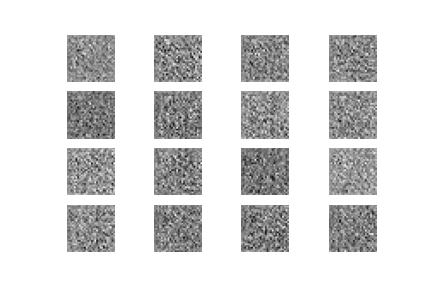

In [20]:
# using display function to print out the image
from IPython import display

image0 = 'output/GAN_MNIST_Fashion_Training_Plot000.png'
display.Image(image0)

Frow the plot above, we can see that the first plot are images look more like random noise. 

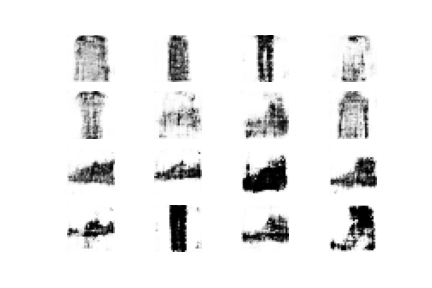

In [21]:
image1000 = 'output/GAN_MNIST_Fashion_Training_Plot1000.png'
display.Image(image1000)

The preceding images are the plots after 1000 iterations. From these images, we can see semblance of the real fashion image. The fashion fake images become more pronounced. 

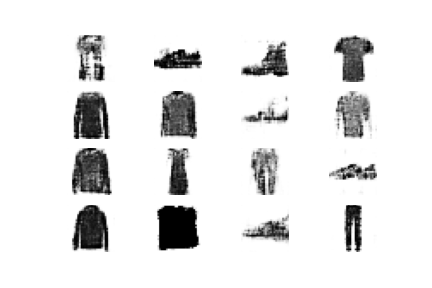

In [22]:
image2000 = 'output/GAN_MNIST_Fashion_Training_Plot2000.png'
display.Image(image2000)

The preceding images are the plots after 2000 iterations. From these images, we can see that the fake fashion images are looking very similar to the real fashion images. However, some of the shapes of the shoes(second one of the first row, third one of the second row) are not really clear but it is clear enough to realize by human eyes. 

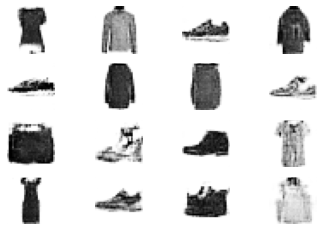

In [25]:
# Images predicted after training
x_fake = fakedataGenerator(Genmodel,16,infeats)
# Visualizing the plots
for j in range(4*4):
    pyplot.subplot(4,4,j+1)
    # turn off axis 
    pyplot.axis('off')
    pyplot.imshow(x_fake[j,:,:,0],cmap='gray_r')

From the plot above, we can clearly see that the fake images look very similar to the real fashion images. We can clearly see some shoes, dress, clothes look very similar to the real fashion images.The accuracy of the discriminator model are around 0.5, which indicated the model performance is desired. 